In [11]:
# Import Library

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
# from wordcloud import WordCloud
import pickle
import joblib
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [12]:
data = pd.read_csv('dataset/Fake_Real_News_Dataset.csv')

In [13]:
data.head()

,berita,label
0,"""Dalam sesuap daging ikan lele, terkandung 3.0...",1
1,Bahaya Mengkonsumsi Ikan Lele Yang Mengandung ...,1
2,"Di jejaring sosial, banyak beredar informasi y...",1
3,Ikan lele disebut-sebut mengandung 3.000 sel k...,1
4,BENARKAH setiap sesuap daging ikan lele dapat ...,1


In [14]:
data['label'].unique()

array([1, 0], dtype=int64)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   berita  956 non-null    object
 1   label   956 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.1+ KB


<AxesSubplot:xlabel='label', ylabel='count'>

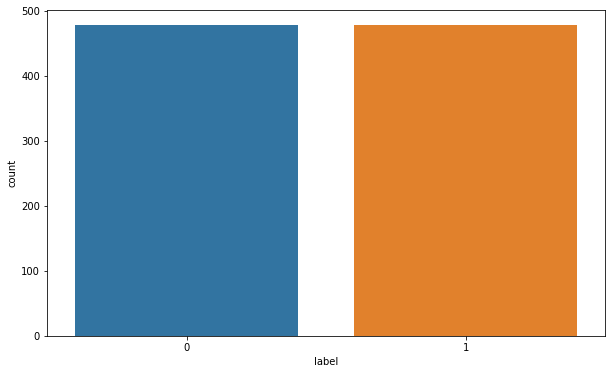

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'label', data = data)

In [17]:
print(f'Total jumlah data {data.shape[0]} data\n')

print(f'Total jumlah data dengan label False/Hoax {data[data.label == 1].shape[0]} data')
print(f'Total jumlah data dengan label True/Fact {data[data.label == 0].shape[0]} data')

Total jumlah data 956 data

Total jumlah data dengan label False/Hoax 478 data
Total jumlah data dengan label True/Fact 478 data


# preprocessing

In [18]:
import re

def text_preprocessing(text):
  text = text.lower()                               
  text = re.sub(r'https?://\S+|www\.\S+', '', text) 
  text = re.sub(r'[-+]?[0-9]+', '', text)           
  text = re.sub(r'[^\w\s]','', text)
  text = re.sub(r'ï½','', text)
  text = re.sub(r'ï¿½','', text)
  text = re.sub(r'\n',' ', text)                                         
  text = text.strip()                               
  return text

In [19]:
%time data['berita'] = data['berita'].apply(text_preprocessing)

CPU times: total: 78.1 ms
Wall time: 86.8 ms


# Train & Test Data Splitting

In [20]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size = 0.2)
df_val, df_test = train_test_split(df_test, test_size = 0.5)

In [21]:
print(f'Data Latih    = {df_train.shape}')
print(f'Data Uji      = {df_test.shape}')
print(f'Data Validasi = {df_val.shape}')

Data Latih    = (764, 2)
Data Uji      = (96, 2)
Data Validasi = (96, 2)


# Load Tokenizer

In [22]:
# Menentukan Pretrained model yang akan digunakan untuk fine-tuning
# 1 = https://huggingface.co/indobenchmark/indobert-base-p2
# 2 = https://huggingface.co/indolem/indobert-base-uncased

PRE_TRAINED_MODEL = 'indolem/indobert-base-uncased'

In [23]:
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model

In [24]:
# Melihat vocabulary dari pre-trained model yang telah di load sebelumnya

vocabulary = bert_tokenizer.get_vocab()

In [25]:
# Contoh Tokenisasi

id_data = 2 # Mengambil data indeks ke-5 pada dataframe

print('Kalimat:', data.berita[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.berita[id_data]))

Kalimat: di jejaring sosial banyak beredar informasi yang menyebut lele sebagai ikan paling jorok dalam sesuap daging ikan lele terkandung  sel kanker julukan sebagai ikan paling jorok merujuk pada sifat lele yang doyan mengonsumsi segala jenis limbah di perairan bahkan sebuah artikel yang cukup viral di internet menyebutkan kotoran manusia juga dijadikan pakan pada sebuah budidaya lele di kota haikou china ikan ini dilengkapi alat pernapasan tambahan berupa labirin sehingga mampu bertahan hidup dalam kondisi perairan berlumpur atau bahkan tercemar agaknya hal inilah yang memunculkan dugaan soal akumulasi racun karsinogen penyebab kanker di tubuh ikan lele investigasi ikan lele yang beredar di pasaran bukan berasal dari alam liar lele banyak dibudidayakan di kolamkolam yang mestinya bisa dikendalikan agar bebas dari pencemaran pakan yang diberikan juga bisa dipilih tidak harus mengandalkan limbah jumlah produksi lele juga terus meningkat setiap tahunnya data kementerian kelautan dan pe

## Input Formatting

In [26]:
# Membuat fungsi formatting untuk BERT

bert_input = bert_tokenizer.encode_plus(
    data.berita[id_data],
    add_special_tokens = True,
    padding = 'max_length',
    truncation = 'longest_first',
    max_length = 50,
    return_attention_mask = True, 
    return_token_type_ids = True
)

# Fungsi encode plus mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
print('Kalimat \t\t', data.berita[id_data])
print('Tokenizer \t', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))
print('Input IDs \t', bert_input['input_ids'])
print('Token Type IDs \t', bert_input['token_type_ids'])
print('Attention Mask \t', bert_input['attention_mask'])

Kalimat 		 di jejaring sosial banyak beredar informasi yang menyebut lele sebagai ikan paling jorok dalam sesuap daging ikan lele terkandung  sel kanker julukan sebagai ikan paling jorok merujuk pada sifat lele yang doyan mengonsumsi segala jenis limbah di perairan bahkan sebuah artikel yang cukup viral di internet menyebutkan kotoran manusia juga dijadikan pakan pada sebuah budidaya lele di kota haikou china ikan ini dilengkapi alat pernapasan tambahan berupa labirin sehingga mampu bertahan hidup dalam kondisi perairan berlumpur atau bahkan tercemar agaknya hal inilah yang memunculkan dugaan soal akumulasi racun karsinogen penyebab kanker di tubuh ikan lele investigasi ikan lele yang beredar di pasaran bukan berasal dari alam liar lele banyak dibudidayakan di kolamkolam yang mestinya bisa dikendalikan agar bebas dari pencemaran pakan yang diberikan juga bisa dipilih tidak harus mengandalkan limbah jumlah produksi lele juga terus meningkat setiap tahunnya data kementerian kelautan dan 

## Menentukan panjang Sequence

Text(0.5, 0, 'Token Count')

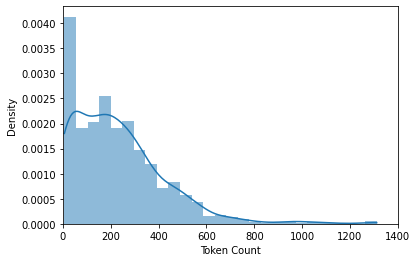

In [28]:
token_lens = []

for txt in data.berita:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

# Plot

sns.histplot(token_lens, kde = True, stat = 'density', linewidth = 0)
plt.xlim([0, 1400])
plt.xlabel('Token Count')

In [29]:
MAX_LEN = 512

## Input Formating pada Data Latih dan Data Uji

In [30]:
def convert_example_to_feature(sentence):
    return bert_tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = 'longest_first',
        max_length = MAX_LEN,
        return_attention_mask = True,
        return_token_type_ids = True
    )

In [31]:
# Fungsi untuk memetakan input hasil input formatting agar sesuai dengan model BERT

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [32]:
# Fungsi iterasi pada setiap kalimat 

def encode(data):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    for sentence, label in data.to_numpy():

        bert_input = convert_example_to_feature(sentence)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                                attention_mask_list,
                                                token_type_ids_list,
                                                label_list)).map(map_example_to_dict)

In [53]:
# Menentukan Hyperparameter

EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 5e-5

In [34]:
# Melakukan input Formatting pada keseluruhan data

train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

# Load PreTrained Model

In [35]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels = 2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer = optimizer, loss = loss, metrics = [metric])

# Fine Tuning

In [54]:
%%time 

bert_history = bert_model.fit(train_encoded,
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                validation_data = val_encoded)

Epoch 1/10
 1/96 [..............................] - ETA: 31:03 - loss: 0.3671 - accuracy: 1.0000

KeyboardInterrupt: 

In [76]:
model_new = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels = 2, from_pt=True)
model_new.load_weights("nyoba_plis_dpt_89.h5")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
# Sample text
input_text = 'Presiden Joko Widodo memastikan bahwa stok vaksin Covid-19 dosis ketiga atau booster yang dimiliki pemerintah mencukupi. Oleh karenanya, ia kembali mendorong masyarakat untuk segera mendapatkan vaksinasi tersebut. "Stok vaksin Covid-19 pemerintah untuk booster lebih dari cukup," kata Jokowi melalui tayangan YouTube Sekretariat Presiden, Senin (30/5/2022).'

In [78]:
input_text_tokenized =  bert_tokenizer.encode(input_text,
                                              truncation = True,
                                              padding = 'max_length',
                                              return_tensors = 'tf')

In [79]:
bert_predict = model_new(input_text_tokenized)
bert_output = tf.nn.softmax(bert_predict[0], axis = -1)
kategori = ['Valid', 'Hoax']
label = tf.argmax(bert_output, axis = 1)
label = label.numpy()

In [80]:
print('Narasi         : ', input_text)
print('Hasil prediksi : ', kategori[label[0]])

Narasi         :  Presiden Joko Widodo memastikan bahwa stok vaksin Covid-19 dosis ketiga atau booster yang dimiliki pemerintah mencukupi. Oleh karenanya, ia kembali mendorong masyarakat untuk segera mendapatkan vaksinasi tersebut. "Stok vaksin Covid-19 pemerintah untuk booster lebih dari cukup," kata Jokowi melalui tayangan YouTube Sekretariat Presiden, Senin (30/5/2022).
Hasil prediksi :  Valid


pickle

In [83]:
pickle.dump(model_new, open("trymodel1.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://2337646e-980a-4140-872a-5e9a8130afd9/assets


INFO:tensorflow:Assets written to: ram://2337646e-980a-4140-872a-5e9a8130afd9/assets


In [84]:
model = pickle.load(open("trymodel1.pkl", 'rb'))

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://d5366882-916b-42d4-8301-a1e10d1fdeb7/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [49]:
inputan = input("text :")
input_text_tokenized =  bert_tokenizer.encode(inputan,
                                              truncation = True,
                                              padding = 'max_length',
                                              return_tensors = 'tf')

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.


In [55]:
bert_predict = model(input_text_tokenized)
bert_output = tf.nn.softmax(bert_predict[0], axis = -1)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
kategori = ['Valid', 'Hoax']
label = tf.argmax(bert_output, axis = 1)
label = label.numpy()

In [ ]:
print('Narasi         : ', inputan)
print('Hasil prediksi : ', kategori[label[0]])